In [298]:
#Import libraries/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error as rmse
from statsmodels.tsa.stattools import adfuller

***************************************************** 1st (BASE) VAR model ****************************

In [155]:
#Import data in drive
climacell = pd.read_csv("/content/drive/MyDrive/Assignment/climacell_data_formodel.csv", index_col = 0, parse_dates = [0, 1])
print("climacell shape: ", climacell.shape)
weather = pd.read_csv("/content/drive/MyDrive/Assignment/weather_data_from_plant.csv",  index_col = 0, parse_dates = ['date_time'])
print("weather shape: ", weather.shape)

print("climacell columns: ", climacell.columns)
print("weather columns: ", weather.columns)

climacell shape:  (2952, 5)
weather shape:  (79912, 3)
climacell columns:  Index(['date', 'time', 'irradiance', 'ambient_temp', 'wind_speed'], dtype='object')
weather columns:  Index(['ambient_temp', 'wind_speed', 'irradiance'], dtype='object')


In [ ]:
########################################### Data Exploration and transformation ######################################
# 1) climacell Data
climacell.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2952 entries, 2020-08-20 06:05:00+05:30 to 2020-10-20 12:00:00+05:30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2952 non-null   datetime64[ns]
 1   time          2952 non-null   object        
 2   irradiance    2952 non-null   int64         
 3   ambient_temp  2952 non-null   float64       
 4   wind_speed    2952 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 138.4+ KB


In [ ]:
climacell.head() #with GMT +5:30 datetime

,date,time,irradiance,ambient_temp,wind_speed
date_time,,,,,
2020-08-20 06:05:00+05:30,2020-08-20,06:05:00,0,28.58,6.33
2020-08-20 06:10:00+05:30,2020-08-20,06:10:00,0,28.57,6.26
2020-08-20 06:15:00+05:30,2020-08-20,06:15:00,0,28.57,6.18
2020-08-20 06:20:00+05:30,2020-08-20,06:20:00,0,28.56,6.11
2020-08-20 06:25:00+05:30,2020-08-20,06:25:00,0,28.56,6.03


In [ ]:
# 2) weather data
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79912 entries, 2020-08-21 06:26:01+00:00 to 2020-10-20 13:01:01+00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ambient_temp  79912 non-null  float64
 1   wind_speed    79912 non-null  float64
 2   irradiance    79912 non-null  float64
dtypes: float64(3)
memory usage: 2.4 MB


In [ ]:
weather.head()

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 06:26:01+00:00,28.185780,0.28164,0.000000
2020-08-21 06:27:01+00:00,28.185780,0.28164,0.000000
2020-08-21 06:28:01+00:00,28.185780,0.28164,0.000000
2020-08-21 06:29:01+00:00,28.185780,0.28164,0.000000
2020-08-21 06:30:01+00:00,28.170719,0.28164,3.442247


No missing data in weather & climacell data

Let's resample the data into 30-minute intervals for both datasets

  ***********1st VAR model************
  
  -----------------------------------------------------------------------------------------------------

In [156]:
#Create a 30 minute resample
weather = weather.resample('30T').mean()
climacell = climacell.resample('30T').mean()

In [ ]:
climacell.head()

,irradiance,ambient_temp,wind_speed
date_time,,,
2020-08-20 06:00:00+05:30,0.0,28.568000,6.182000
2020-08-20 06:30:00+05:30,0.0,28.575000,6.083333
2020-08-20 07:00:00+05:30,0.0,28.635000,6.390000
2020-08-20 07:30:00+05:30,30.0,28.746667,6.430000
2020-08-20 08:00:00+05:30,30.0,28.938333,6.100000


In [ ]:
weather.head()

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 06:00:00+00:00,28.185780,0.28164,0.000000
2020-08-21 06:30:00+00:00,28.207668,0.28164,13.538776
2020-08-21 07:00:00+00:00,28.402197,0.28164,38.665204
2020-08-21 07:30:00+00:00,28.452422,0.28164,55.529910
2020-08-21 08:00:00+00:00,28.809948,0.28164,129.301768


After resampling, lets fill rows if missing rows were generated

In [157]:
if weather.isnull().values.any():
  weather = weather.fillna(0)
if climacell.isnull().values.any():
  climacell = climacell.fillna(0)

for j in ['wind_speed', 'ambient_temp']:
    for i in range(len(weather)):
       if weather[j][i] == 0:
           weather[j][i] = weather[j][i-1]

for j in ['wind_speed', 'ambient_temp']:
    for i in range(len(climacell)):
       if climacell[j][i] == 0:
           climacell[j][i] = climacell[j][i-1]

In [124]:
climacell.isnull().sum() #values have been imputed

irradiance      0
ambient_temp    0
wind_speed      0
dtype: int64

climacell  ambient_temp


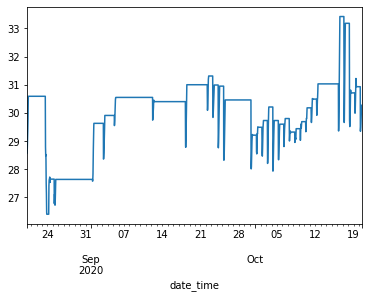

weather  ambient_temp


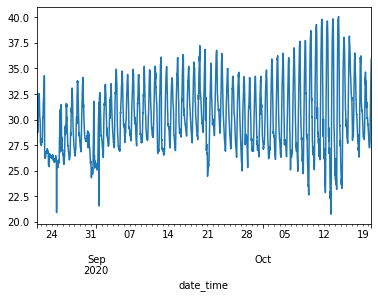

climacell  wind_speed


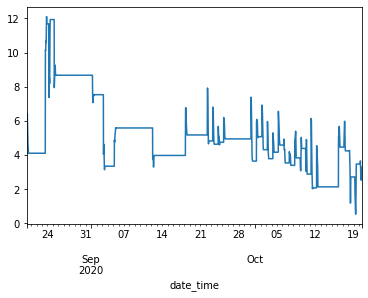

weather  wind_speed


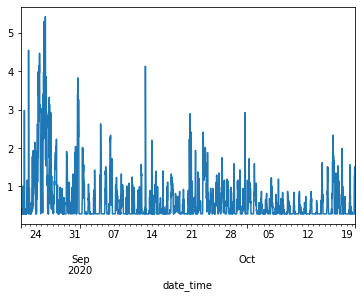

In [ ]:

#see the individual features
for x in ['ambient_temp', 'wind_speed']:
  print("climacell ", x)
  climacell[x].plot()
  plt.show()
  print("weather ", x)
  weather[x].plot()
  plt.show()

Visually, the stationarity is not that poor in the datasets.

In [ ]:
#check causality of our features
from statsmodels.tsa.stattools import grangercausalitytests
for col in ['wind_speed', 'ambient_temp']:
  print('weather', ", ", col)
  result = grangercausalitytests(weather[['irradiance', col]], 5, verbose = False)
  p_val = [result[i+1][0]['ssr_ftest'][1] for i in range(5)]
  print(p_val, "\n")

  print('climacell', ", ", col)
  result = grangercausalitytests(climacell[['irradiance', col]], 5, verbose=False)
  p_val = [result[i+1][0]['ssr_ftest'][1] for i in range(5)]
  print(p_val, "\n")

weather ,  wind_speed
[0.13132406350215997, 0.1669541249541068, 0.058716616025079056, 0.0552391274777436, 0.30099338245917673] 

climacell ,  wind_speed
[0.5617254898874892, 0.0022900025068894403, 0.0010765821703036722, 0.001386265321035155, 0.002052519942168336] 

weather ,  ambient_temp
[4.866428424678788e-66, 4.926011122020764e-55, 3.2916508005261995e-30, 1.2277903520404537e-14, 2.8301455501675473e-07] 

climacell ,  ambient_temp
[0.02873546779683406, 7.776173146357513e-11, 4.4342235547075955e-13, 1.365895153870976e-12, 1.3969146545224158e-13] 



When p value for a feature is >0.05, we fail to reject the Null Hypothesis and means that feature has no significance in determining our irradiance variable.

From the above analysis of causality we conclude that:

1)climacell's wind_speed is significant at lags [2, 3, 4, 5]

2)weather's ambient_temp is significant at lags [1, 2, 3, 4, 5] {all}

3)climacell's ambient_temp is significant at lags [1, 2, 3, 4, 5] {all}

False

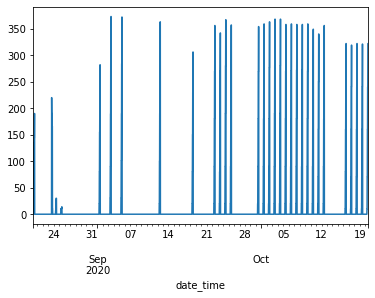

In [ ]:
######################## Using climacell's data #######################
climacell.irradiance.plot()
climacell.isnull().values.any() #False

In [158]:
#split data
train = climacell[:int(0.8*(climacell.shape[0]))]
test = climacell[int(0.8*(climacell.shape[0])):]

#only taking ambient_temp and irradience past values to predict irradiance 
train = train.drop(['wind_speed'], axis=1) 
test = test.drop(['wind_speed'], axis=1)

In [159]:

#find optimum lag using aic of var model
model = VAR(train, freq = '30T')
model.select_order(48).summary() #find lags = 47



,AIC,BIC,FPE,HQIC
0,8.469,8.474,4766.,8.471
1,3.030,3.045,20.70,3.036
2,3.000,3.025,20.09,3.009
3,2.994,3.029,19.96,3.006
4,2.987,3.031,19.82,3.003
5,2.985,3.040,19.79,3.005
6,2.968,3.033,19.46,2.992
7,2.966,3.040,19.41,2.993
8,2.921,3.006,18.57,2.952
9,2.912,3.007,18.40,2.947


In [165]:
order = 47  #from aic
result = model.fit(order)
step =test.shape[0]
lag = result.k_ar #lag to get first forecast and the next and so on = 47
pred = result.forecast(train.values[-lag:], steps = step)


In [161]:

print(test[0:step])
print("\t\t")
print(pred)


                           irradiance  ambient_temp
date_time                                          
2020-10-08 06:00:00+05:30         0.0     29.030000
2020-10-08 06:30:00+05:30         0.0     28.951667
2020-10-08 07:00:00+05:30         0.0     28.968333
2020-10-08 07:30:00+05:30        20.0     29.000000
2020-10-08 08:00:00+05:30        20.0     29.048333
...                               ...           ...
2020-10-20 10:00:00+05:30       160.0     30.096667
2020-10-20 10:30:00+05:30       240.0     30.173333
2020-10-20 11:00:00+05:30       240.0     30.208333
2020-10-20 11:30:00+05:30       322.0     30.246667
2020-10-20 12:00:00+05:30       322.0     30.270000

[589 rows x 2 columns]
		
[[ 4.16475783 28.46604052]
 [ 0.25202082 28.43851917]
 [ 1.94779771 28.48174503]
 ...
 [14.20129338 29.54067363]
 [14.29334138 29.54095847]
 [14.33341305 29.54129613]]


We can compare test data above and the predicted array.

Forecast for irradiance (target) was not close. But for other variables the model was pretty spot on.

Most probably our irradiance doesn't have a clear causality-relationship with ambient_temp variable.

In [166]:
pred_df = pd.DataFrame(pred, columns = ['irradiance', 'ambient_temp'], index = test[0:step].index)
t = test[0:step]['irradiance']
pred_df.head()

,irradiance,ambient_temp
date_time,,
2020-10-08 06:00:00+05:30,4.164758,28.466041
2020-10-08 06:30:00+05:30,0.252021,28.438519
2020-10-08 07:00:00+05:30,1.947798,28.481745
2020-10-08 07:30:00+05:30,11.639887,28.524387
2020-10-08 08:00:00+05:30,11.134431,28.669254


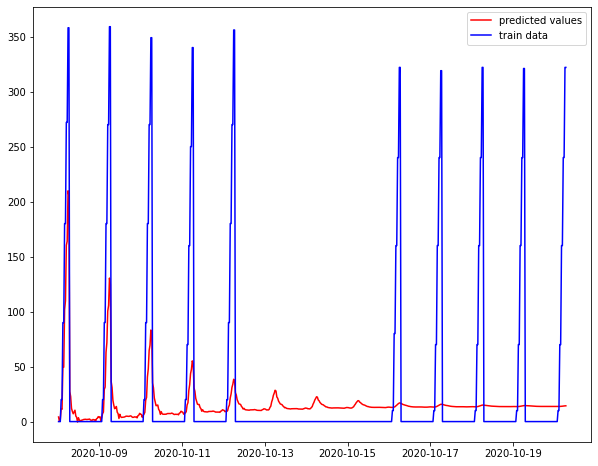

In [167]:
plt.figure(figsize=(10, 8))
plt.plot(pred_df['irradiance'], color='red', label="predicted values")                   #predicted values
plt.plot(t, color='blue', label="train data")     #original train data
plt.legend()
plt.show()

In [168]:
#rmse form sklearn
score = rmse(t, pred_df['irradiance'])
score

5073.9005782023205

In [169]:

#rmse from scratch
sum_error = 0
for i in range(test.shape[0]):
		error = pred_df.irradiance[i] - t[i]
		sum_error += (error ** 2)
mean_error = sum_error / float(step)
print(np.sqrt(mean_error))

71.2313173976329


  -----------------------------------------------------------------------------------------------------

******************** 2nd VAR model with feature engineering  ****************************

In [238]:
#Import data in drive
climacell = pd.read_csv("/content/drive/MyDrive/Assignment/climacell_data_formodel.csv", index_col = 0) #index is datetime but in string
print("climacell shape: ", climacell.shape)
print("climacell columns: ", climacell.columns)

climacell shape:  (2952, 5)
climacell columns:  Index(['date', 'time', 'irradiance', 'ambient_temp', 'wind_speed'], dtype='object')


In [239]:
#extract data from date & time like month, year, day, date, hour, minute, second (no need to dummify)
climacell['minute'] = pd.to_datetime(climacell['time']).dt.minute
climacell['hour'] = pd.to_datetime(climacell['time']).dt.hour
climacell['day'] = pd.to_datetime(climacell['date']).dt.day
climacell['month'] = pd.to_datetime(climacell['date']).dt.month
#climacell['year'] = pd.to_datetime(climacell['date']).dt.year   #Single year 2020 in the data gives us no insight into the data, so we will ignore

climacell.head(2)

,date,time,irradiance,ambient_temp,wind_speed,minute,hour,day,month
date_time,,,,,,,,,
2020-08-20 06:05:00+05:30,20-08-2020,06:05:00,0,28.58,6.33,5,6,20,8
2020-08-20 06:10:00+05:30,20-08-2020,06:10:00,0,28.57,6.26,10,6,20,8


In [240]:
#extract 'day' of the week
climacell['day_name'] = climacell['date'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y").strftime("%A"))
climacell.tail(3)

,date,time,irradiance,ambient_temp,wind_speed,minute,hour,day,month,day_name
date_time,,,,,,,,,,
2020-10-20 11:50:00+05:30,20-10-2020,11:50:00,322,30.26,3.19,50,11,20,10,Tuesday
2020-10-20 11:55:00+05:30,20-10-2020,11:55:00,322,30.26,3.24,55,11,20,10,Tuesday
2020-10-20 12:00:00+05:30,20-10-2020,12:00:00,322,30.27,3.28,0,12,20,10,Tuesday


In [241]:
climacell.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2952 entries, 2020-08-20 06:05:00+05:30 to 2020-10-20 12:00:00+05:30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          2952 non-null   object 
 1   time          2952 non-null   object 
 2   irradiance    2952 non-null   int64  
 3   ambient_temp  2952 non-null   float64
 4   wind_speed    2952 non-null   float64
 5   minute        2952 non-null   int64  
 6   hour          2952 non-null   int64  
 7   day           2952 non-null   int64  
 8   month         2952 non-null   int64  
 9   day_name      2952 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 253.7+ KB


Before we resample to 30 minute intervals, we will create encoding variables (sparse matrix) from 'day_name' to remove the string variable

In [242]:
#encoding day_name into numerical - dummies will remove relationship between the variables and their closeness
dic = {'Sunday': 0,'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday':5, 'Saturday':6}
for i in range(len(climacell.day_name)):
  climacell['day_name'][i] = float(dic[climacell['day_name'][i]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [243]:
climacell.day_name = climacell.day_name.astype(float)
climacell.head(3)

,date,time,irradiance,ambient_temp,wind_speed,minute,hour,day,month,day_name
date_time,,,,,,,,,,
2020-08-20 06:05:00+05:30,20-08-2020,06:05:00,0,28.58,6.33,5,6,20,8,4.0
2020-08-20 06:10:00+05:30,20-08-2020,06:10:00,0,28.57,6.26,10,6,20,8,4.0
2020-08-20 06:15:00+05:30,20-08-2020,06:15:00,0,28.57,6.18,15,6,20,8,4.0


climacell  ambient_temp


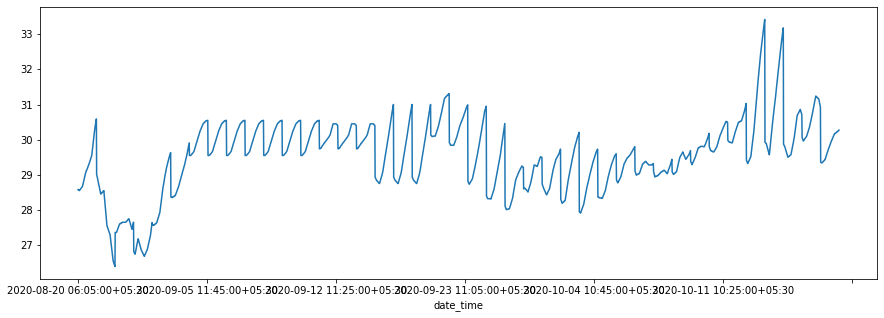

climacell  wind_speed


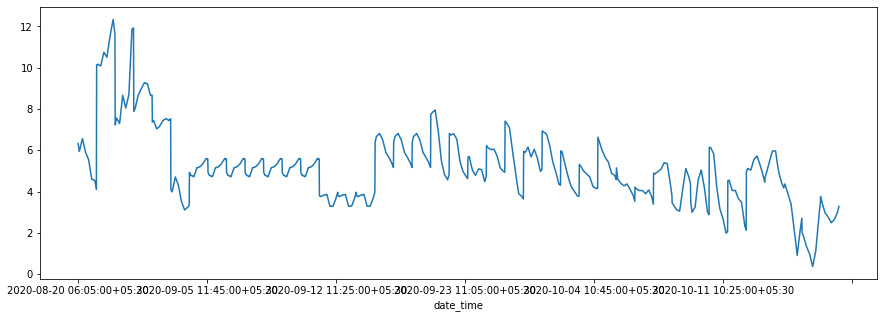

climacell  minute


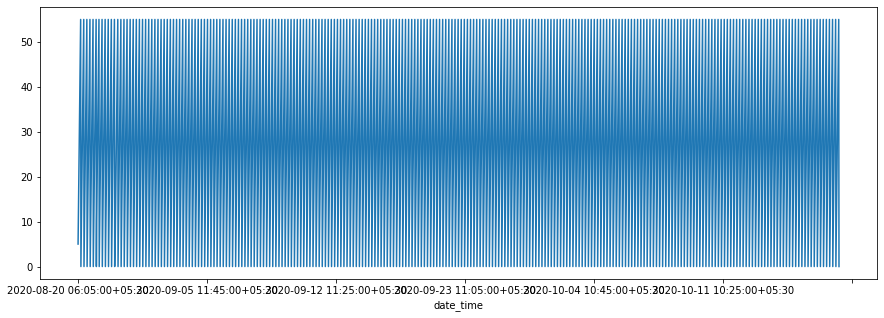

climacell  hour


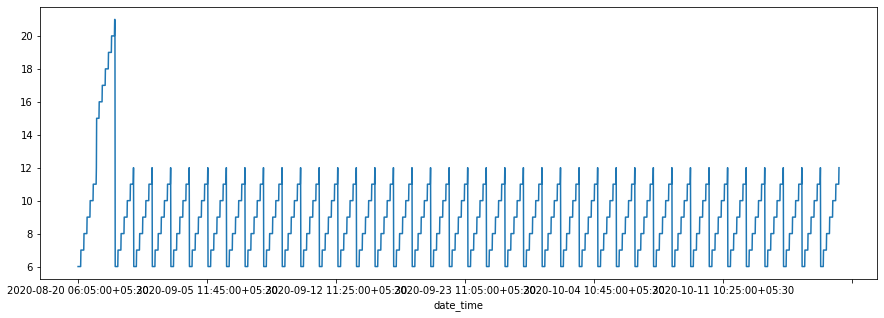

climacell  day


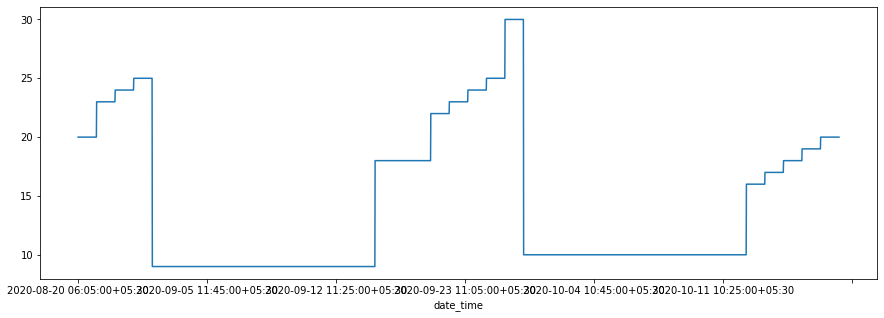

climacell  day_name


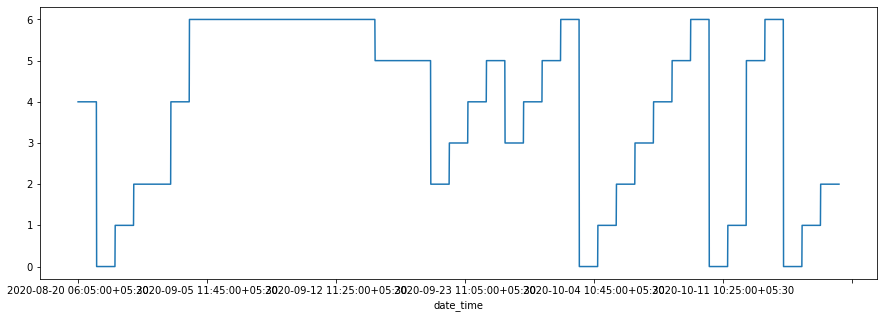

In [244]:
#Look at the features
for x in ['ambient_temp', 'wind_speed', 'minute', 'hour', 'day', 'day_name']:
  plt.figure(figsize = (15,5))
  print("climacell ", x)
  climacell[x].plot()
  plt.show()

In [245]:
#Create a 30 minute resample after reconverting index to datetime (due to error)
climacell.index = pd.to_datetime(climacell.index)
climacell = climacell.resample('30T').mean()

climacell.head(3)

,irradiance,ambient_temp,wind_speed,minute,hour,day,month,day_name
date_time,,,,,,,,
2020-08-20 06:00:00+05:30,0.0,28.568,6.182000,15.0,6.0,20.0,8.0,4.0
2020-08-20 06:30:00+05:30,0.0,28.575,6.083333,42.5,6.0,20.0,8.0,4.0
2020-08-20 07:00:00+05:30,0.0,28.635,6.390000,12.5,7.0,20.0,8.0,4.0


In [246]:
climacell.isnull().values.any()

True

In [247]:
#impute missing values with previous values

for j in climacell.columns:
    for i in range(len(climacell)):
       if np.isnan(climacell[j][i]):
           climacell[j][i] = climacell[j][i-1]

In [248]:
climacell.isnull().values.any()

False

climacell  irradiance


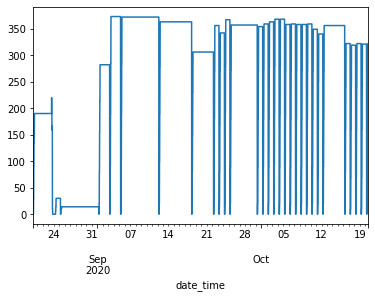

climacell  ambient_temp


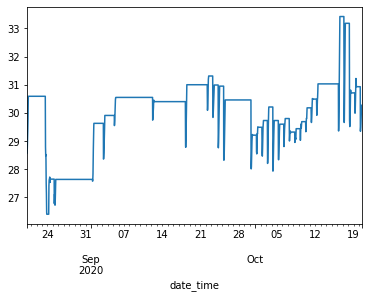

climacell  wind_speed


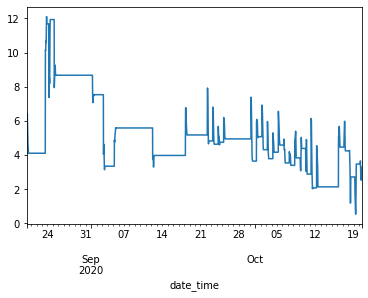

climacell  minute


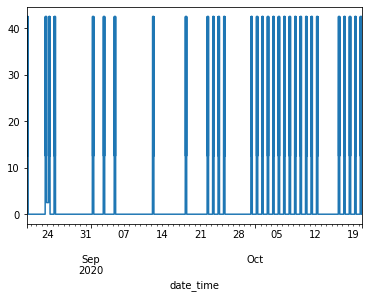

climacell  hour


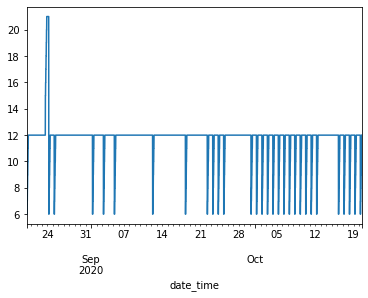

climacell  day


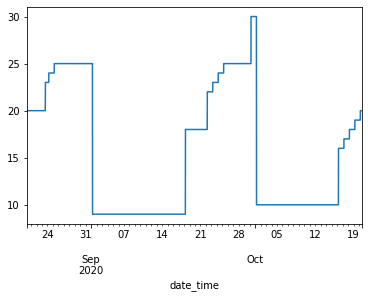

climacell  month


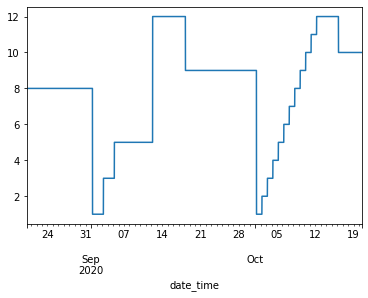

climacell  day_name


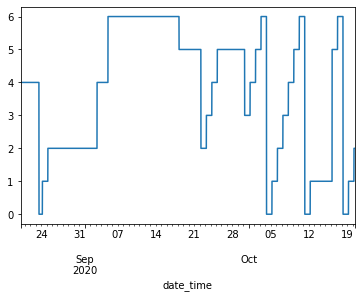

In [74]:
for x in climacell.columns:
  print("climacell ", x)
  climacell[x].plot()
  plt.show()

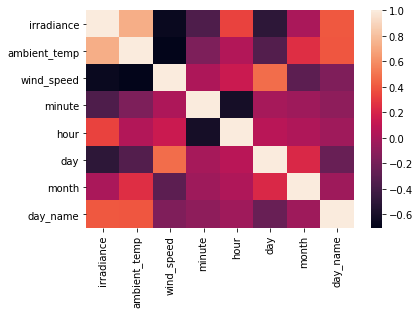

In [249]:
#see correlation of features
sns.heatmap(climacell.corr())

From above, we will only take ambient_temp, hour and day_name with irradiance

In [250]:
#split data
data = climacell[['irradiance', 'ambient_temp', 'hour', 'day_name']]
train = climacell[:int(0.8*(data.shape[0]))]
test = climacell[int(0.8*(data.shape[0])):]


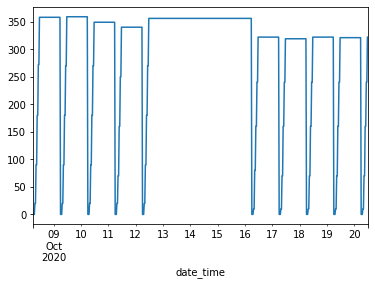

In [251]:
test['irradiance'].plot() #test data looks like this

In [252]:
#find optimum lag using aic of var model
model = VAR(train, freq = '30T')
model.select_order(48).summary() #14 or 43 - 43 works best

,AIC,BIC,FPE,HQIC
0,19.66,19.68,3.462e+08,19.67
1,-7.499,-7.320,0.0005535,-7.434
2,-8.962,-8.623,0.0001282,-8.838
3,-9.121,-8.623,0.0001093,-8.940
4,-9.141,-8.483,0.0001072,-8.901
5,-9.188,-8.370,0.0001023,-8.890
6,-9.167,-8.190,0.0001044,-8.811
7,-9.204,-8.067,0.0001007,-8.789
8,-9.243,-7.947,9.676e-05,-8.771
9,-9.303,-7.847,9.121e-05,-8.772


In [253]:
step = test.shape[0]
result = model.fit(43)  

lag = result.k_ar #lag to get first forecast
pred = result.forecast(train.values[-lag:], steps = step)


In [254]:
pred_df = pd.DataFrame(pred, columns = train.columns, index = test[0:step].index)
t = test[0:step]['irradiance']

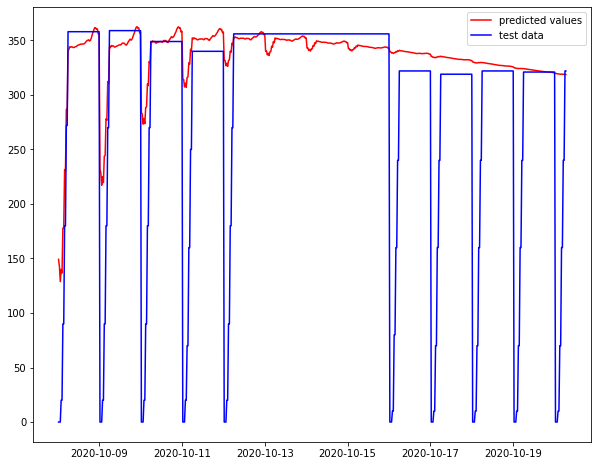

In [255]:
plt.figure(figsize=(10, 8))
plt.plot(pred_df['irradiance'], color='red', label="predicted values")                   #predicted values
plt.plot(t, color='blue', label="test data")     #original train data
plt.legend()
plt.show()

In [256]:
#rmse form sklearn
score = rmse(t, pred_df['irradiance'])
score

10155.260649208587

In [257]:

#rmse from scratch
sum_error = 0
for i in range(test.shape[0]):
		error = pred_df.irradiance[i] - t[i]
		sum_error += (error ** 2)
mean_error = sum_error / float(test.shape[0])
print(np.sqrt(mean_error))

100.77331317967366


  -----------------------------------------------------------------------------------------------------

**********3rd VAR model with weather dataset in VAR model************

In [224]:
#Import data in drive
weather = pd.read_csv("/content/drive/MyDrive/Assignment/weather_data_from_plant.csv",  index_col = 0) #index is datetime but in string
print("weather shape: ", weather.shape)
print("weather columns: ", weather.columns)

weather shape:  (79912, 3)
weather columns:  Index(['ambient_temp', 'wind_speed', 'irradiance'], dtype='object')


In [225]:
#Create a 30 minute resample
weather.index = pd.to_datetime(weather.index)
weather = weather.resample('30T').mean()

In [226]:
weather.isnull().any()

ambient_temp    True
wind_speed      True
irradiance      True
dtype: bool

In [227]:
#impute missing values

for j in weather.columns:
    for i in range(len(weather)):
       if np.isnan(weather[j][i]):
           weather[j][i] = weather[j][i-1]

In [228]:
weather.isnull().values.any()

False

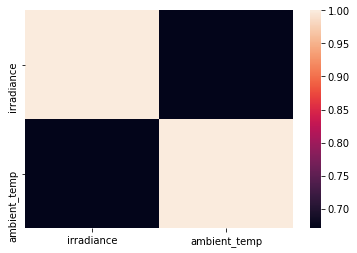

In [229]:
#see correlation of features
sns.heatmap(weather[['irradiance', 'ambient_temp']].corr()) #not relevant to irradiance

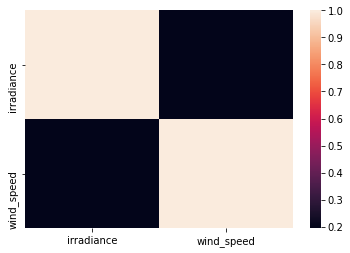

In [100]:
#see correlation of features
sns.heatmap(weather[['irradiance', 'wind_speed']].corr()) #not relevant to irradiance

This correlation is in respect to linear relationship and so we will still proceed.

In [230]:
#split data
data = weather
train = data[:int(0.8*(data.shape[0]))]
test = data[int(0.8*(data.shape[0])):]


In [231]:
#find optimum lag using aic of var model
model = VAR(train, freq = '30T')
model.select_order(48).summary() #48

,AIC,BIC,FPE,HQIC
0,12.09,12.10,1.779e+05,12.09
1,5.015,5.045,150.6,5.026
2,4.923,4.976,137.4,4.942
3,4.875,4.951,131.0,4.903
4,4.847,4.946*,127.4,4.883
5,4.827,4.948,124.8,4.871*
6,4.825,4.969,124.6,4.878
7,4.826,4.992,124.7,4.887
8,4.823,5.013,124.4,4.892
9,4.825,5.037,124.5,4.902


In [232]:
step = test.shape[0]
result = model.fit(48)  

lag = result.k_ar #lag to get first forecast
pred = result.forecast(train.values[-lag:], steps = step)


In [233]:
pred_df = pd.DataFrame(pred, columns = train.columns, index = test[0:step].index)
t = test[0:step]['irradiance']

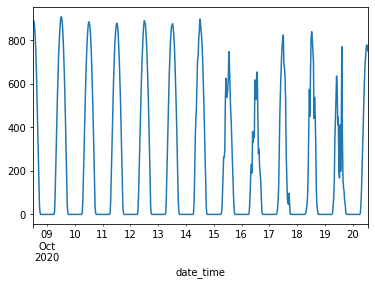

In [234]:
t.plot() #test data looks like this

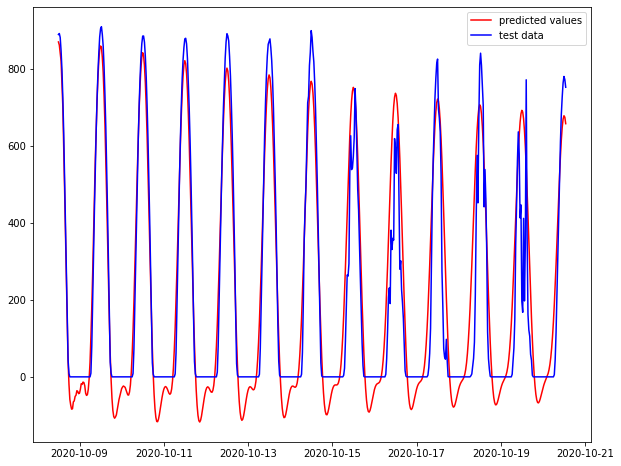

In [235]:
plt.figure(figsize=(10, 8))
plt.plot(pred_df['irradiance'], color='red', label="predicted values") #predicted values
plt.plot(t, color='blue', label="test data")     #original train data
plt.legend()
plt.show()

In [236]:
#rmse from library
score = rmse(t, pred_df['irradiance'])
score

10920.988927971968

In [237]:

#rmse from scratch
sum_error = 0
for i in range(test.shape[0]):
		error = pred_df.irradiance[i] - t[i]
		sum_error += (error ** 2)
mean_error = sum_error / float(step)
print(np.sqrt(mean_error))

104.50353548072891


  -----------------------------------------------------------------------------------------------------

********4th VAR model with COMBINED datasets*********

In [348]:
#Import data in drive
climacell = pd.read_csv("/content/drive/MyDrive/Assignment/climacell_data_formodel.csv", index_col = 0, parse_dates = [0, 1])
print("climacell shape: ", climacell.shape)
weather = pd.read_csv("/content/drive/MyDrive/Assignment/weather_data_from_plant.csv",  index_col = 0, parse_dates = ['date_time'])
print("weather shape: ", weather.shape)

print("climacell columns: ", climacell.columns)
print("weather columns: ", weather.columns)

climacell shape:  (2952, 5)
weather shape:  (79912, 3)
climacell columns:  Index(['date', 'time', 'irradiance', 'ambient_temp', 'wind_speed'], dtype='object')
weather columns:  Index(['ambient_temp', 'wind_speed', 'irradiance'], dtype='object')


In [349]:
climacell.drop(['date', 'time'], axis=1, inplace= True) #to make features matching in both datasets

In [350]:
df = pd.concat([climacell.astype(float), weather.astype(float)], axis=0)
df.head()

,irradiance,ambient_temp,wind_speed
date_time,,,
2020-08-20 06:05:00+05:30,0.0,28.58,6.33
2020-08-20 06:10:00+05:30,0.0,28.57,6.26
2020-08-20 06:15:00+05:30,0.0,28.57,6.18
2020-08-20 06:20:00+05:30,0.0,28.56,6.11
2020-08-20 06:25:00+05:30,0.0,28.56,6.03


In [351]:
if climacell.shape[0] + weather.shape[0] == df.shape[0]:
  print(df.shape) #82864, 3

(82864, 3)


In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82864 entries, 2020-08-20 06:05:00+05:30 to 2020-10-20 13:01:01+00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   irradiance    82864 non-null  float64
 1   ambient_temp  82864 non-null  float64
 2   wind_speed    82864 non-null  float64
dtypes: float64(3)
memory usage: 2.5+ MB


In [353]:
df.isnull().any()

irradiance      False
ambient_temp    False
wind_speed      False
dtype: bool

In [354]:
#resample as 30 minute interval
df.index = pd.to_datetime(df.index, utc=True)
df = df.resample('30T').mean()

In [278]:
df.isnull().any()

irradiance      True
ambient_temp    True
wind_speed      True
dtype: bool

In [355]:
#impute missing values as average of past and present

for j in df.columns:
    for i in range(df.shape[0]):
       if np.isnan(df[j][i]):
           df[j][i] = df[j][i-1]

In [356]:
df.isnull().any()

irradiance      False
ambient_temp    False
wind_speed      False
dtype: bool

irradiance


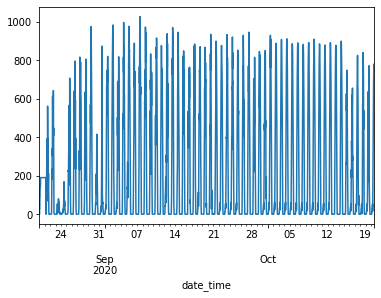

ambient_temp


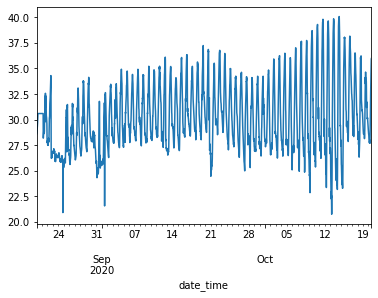

wind_speed


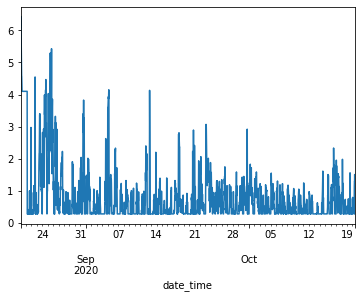

In [286]:
for col in df.columns:
  print(col)
  df[col].plot()
  plt.show()

Wind_Speed and ambient_Temp could be made stationary when seen visually.

Let see statistically...

In [300]:
# DF Test - Alt Hyp = DIFFERENCE stationary

for x in ['ambient_temp', 'wind_speed']:
  print(x)
  test1 = adfuller(df[x], maxlag = 48)
  print("test statistics: ", test1[0])
  print("p-value: ", test1[1])
  print("lags: ", test1[2])
  print("critical values: ", test1[4])
  print("\n")

ambient_temp
test statistics:  -2.511153028437229
p-value:  0.11278420206490791
lags:  48
critical values:  {'1%': -3.4326030422464138, '5%': -2.8625354431090244, '10%': -2.5672999025657584}


wind_speed
test statistics:  -6.651704742574915
p-value:  5.101533132742897e-09
lags:  48
critical values:  {'1%': -3.4326030422464138, '5%': -2.8625354431090244, '10%': -2.5672999025657584}




test statistics < critical value  = Series is NOT Linearly stationary

or p > critical values , so we fail to reject null hypothesis of non stationarity


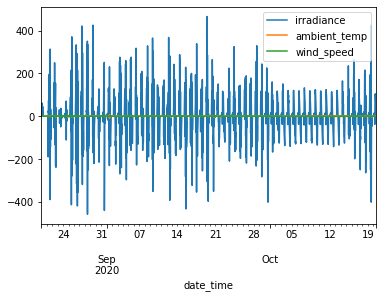

In [357]:
# shifting by 1 and differencing
df = df - df.shift()
df.plot()

In [358]:
df.isnull().any()

irradiance      True
ambient_temp    True
wind_speed      True
dtype: bool

In [359]:
#impute missing values as average of past and present

for j in df.columns:
    for i in range(df.shape[0]):
       if np.isnan(df[j][i]):
           df[j][i] = df[j][i-1]

In [360]:
#split data
train = df[:int(0.8*(df.shape[0]))]
test = df[int(0.8*(df.shape[0])):]


In [361]:
#find optimum lag using aic of var model
model = VAR(train, freq = '30T')
model.select_order(48).summary() #48

,AIC,BIC,FPE,HQIC
0,5.796,5.804,329.1,5.799
1,5.517,5.547,248.9,5.528
2,5.447,5.499,232.0,5.466
3,5.381,5.455,217.2,5.408
4,5.342,5.438*,208.9,5.377
5,5.320,5.439,204.4,5.364
6,5.312,5.453,202.7,5.363
7,5.308,5.472,201.9,5.368
8,5.296,5.482,199.5,5.364
9,5.276,5.484,195.6,5.352


In [362]:
step = test.shape[0]
result = model.fit(48)  

lag = result.k_ar #lag to get first forecast
pred = result.forecast(train.values[-lag:], steps = step)


In [363]:
pred_df = pd.DataFrame(pred, columns = train.columns, index = test[0:step].index)
t = test[0:step]['irradiance']

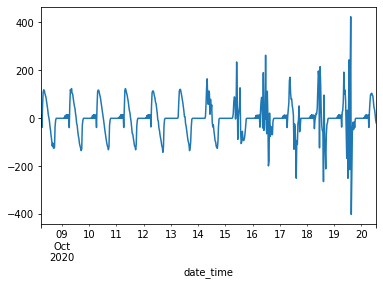

In [364]:
t.plot() #test data looks like this

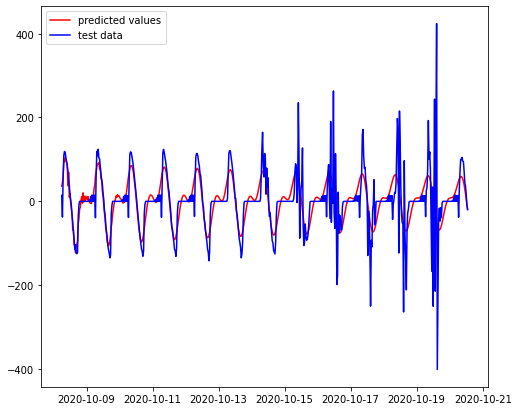

In [365]:
plt.figure(figsize=(8, 7))
plt.plot(pred_df['irradiance'], color='red', label="predicted values") #predicted values
plt.plot(t, color='blue', label="test data")     #original train data
plt.legend()
plt.show()

In [366]:
#rmse from library
score = rmse(t, pred_df['irradiance'])
score

2669.789736698026

In [367]:

#rmse from scratch
sum_error = 0
for i in range(test.shape[0]):
		error = pred_df.irradiance[i] - t[i]
		sum_error += (error ** 2)
mean_error = sum_error / float(step)
print(np.sqrt(mean_error))

51.670008096554675


While making data stationary with differencing, shifting by 7, also worked great.

---------------------------- XXXXX---------------------------------